## Imports

In [338]:
import requests
import bs4
import pandas as pd
from math import radians, cos, sin, asin, sqrt
import numpy as np
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import declarative_base
from sqlalchemy import Column, Integer, Float, String, DateTime, Date
from sqlalchemy.schema import CreateTable

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from datetime import date

## Part 1: Data Preprocessing

### Uber Sample Data Cleaning

In [120]:
# load_data
uber_sample = pd.read_csv("data/uber_rides_sample.csv")

In [80]:
# constraint on longitude and latitude
uber_sample = uber_sample[uber_sample['pickup_longitude']>=-74.242330]
uber_sample = uber_sample[uber_sample['pickup_longitude']<=-73.717047]
uber_sample = uber_sample[uber_sample['pickup_latitude']>=40.560445]
uber_sample = uber_sample[uber_sample['pickup_latitude']<=40.908524]
uber_sample = uber_sample[uber_sample['dropoff_longitude']>=-74.242330]
uber_sample = uber_sample[uber_sample['dropoff_longitude']<=-73.717047]
uber_sample = uber_sample[uber_sample['dropoff_latitude']>=40.560445]
uber_sample = uber_sample[uber_sample['dropoff_latitude']<=40.908524]

In [12]:
# function for calculating distance given longitude and latitude of pickup and dropoff location
def cal_distance(lat1, lat2, long1, long2):
     
    # convert degrees to radians
    long1 = radians(long1)
    long2 = radians(long2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # apply the Haversine formula
    result = sin((lat2 - lat1) / 2)**2 + cos(lat1) * cos(lat2) * sin((long2 - long1) / 2)**2
    result = 2 * asin(sqrt(result))*3956
      
    return result

In [88]:
# unit test for cal_distance
def cal_distance_test():
    assert round(cal_distance(40, 41, 70, 71), 2) == 86.74
cal_distance_test()

In [13]:
# filter out unnecessary columns
uber_cols = ['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
uber_sample_cleaned = uber_sample[uber_cols].reset_index(drop=True)

In [14]:
# calculate distance for each trip and add it to the dataframe
distance = []
for i in range(len(uber_sample_cleaned)):
    data = uber_sample_cleaned.iloc[i,:]
    distance.append(cal_distance(data[2], data[4], data[1], data[3]))
uber_sample_cleaned['distance'] = distance

In [15]:
# save cleaned data to csv
uber_sample_cleaned.to_csv("data/uber_sample_cleaned.csv")

### count number of records in each month

In [16]:
uber_sample_cleaned['year'] = uber_sample_cleaned['pickup_datetime'].apply(lambda x:int(x[:4]))
uber_sample_cleaned['month'] = uber_sample_cleaned['pickup_datetime'].apply(lambda x:int(x[5:7]))

In [17]:
nrows_dict = uber_sample_cleaned.groupby(['year', 'month']).agg({'pickup_datetime':'count'}).to_dict()['pickup_datetime']

In [78]:
uber_sample_cleaned.drop(columns=['year', 'month'], inplace=True)

### Yellow Taxi Data Cleaning

#### Download and Sampling Yellow Taxi Data

In [11]:
# indicator function to check whether the time of the trip is within our desired time range
def isValidTime(year, month):
    if year > 2015 or year < 2009:
        return False
    if year == 2015 and month > 6:
        return False
    return True

In [12]:
# function to automatically scrap all the yellow taxi data within our desired time range
# the input parameter last_month is used to continue on unfinished downloading
def download_yellow_taxi(startpoint=None):
    # use requests to get the html of the yellow taxi page
    response = requests.get("https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page")

    # use beautifulsoup to parse the html
    soup = bs4.BeautifulSoup(response.content, 'html.parser')
    
    if startpoint:
        start = False
    else:
        start = True
    # extract all the urls that point to the csv files of yellow taxi trip records
    for row in soup.find_all(title="Yellow Taxi Trip Records"):
        url = row['href']
        # check if the csv is within our desired time range
        year = int(url[-11:-7])
        month = int(url[-6:-4])
        if (not start) and ((year, month) == startpoint):
            start = True
        if isValidTime(year, month) and start:
            # download the original csv files
            print(url)
            data = requests.get(url)
            fpath = "data/yellow_taxi/yt_{}_{}.csv".format(year, month)
            with open(fpath, 'wb')as file:
                file.write(data.content)
            print("Downloaded Successfully")
        
            temp = pd.read_csv(fpath, error_bad_lines=False)
            temp = temp.sample(nrows_dict[(year, month)]).reset_index(drop=True)
            
            temp.to_csv(fpath)
            print("Written Successfully")

In [18]:
download_yellow_taxi((2010, 4))

https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2010-04.csv
Downloaded Successfully
Written Successfully
https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2010-05.csv
Downloaded Successfully
Written Successfully
https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2010-06.csv
Downloaded Successfully
Written Successfully
https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2010-07.csv
Downloaded Successfully
Written Successfully
https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2010-08.csv
Downloaded Successfully
Written Successfully
https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2010-09.csv
Downloaded Successfully
Written Successfully
https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2010-10.csv
Downloaded Successfully
Written Successfully
https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2010-11.csv
Downloaded Successfully
Written Successfully
https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2010-12.csv
D

In [66]:
# There three different column namings among all the csv
yt_cols_1 = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pickup_longitude', 'pickup_latitude', 
             'dropoff_longitude', 'dropoff_latitude', 'tip_amount']
yt_cols_2 = ['Trip_Pickup_DateTime', 'Trip_Dropoff_DateTime', 'Start_Lon', 'Start_Lat',
             'End_Lon', 'End_Lat', 'Tip_Amt']
yt_cols_3 = ['pickup_datetime', 'dropoff_datetime', 'pickup_longitude', 'pickup_latitude',
             'dropoff_longitude', 'dropoff_latitude', 'tip_amount']

In [147]:
def clean_yellow_taxi():
    yt_sample = pd.DataFrame()
    for key in nrows_dict:
        # read in all the yellow taxi csv
        fpath = "data/yellow_taxi/yt_{}_{}.csv".format(key[0], key[1])
        temp = pd.read_csv(fpath)
        
        # strip the column names as some of them contain leading spaces
        temp.columns = [i.strip() for i in temp.columns]
        
        # select only necessary columns
        if 'tpep_pickup_datetime' in temp.columns:
            temp = temp[yt_cols_1]
        elif 'Trip_Pickup_DateTime' in temp.columns:
            temp = temp[yt_cols_2]
        else:
            temp = temp[yt_cols_3]
            
        # set the column names to be the same
        temp.columns = yt_cols_3
        
        # filter out invalid latitude and longitude
        temp = temp[temp['pickup_longitude']>=-74.242330]
        temp = temp[temp['pickup_longitude']<=-73.717047]
        temp = temp[temp['pickup_latitude']>=40.560445]
        temp = temp[temp['pickup_latitude']<=40.908524]
        temp = temp[temp['dropoff_longitude']>=-74.242330]
        temp = temp[temp['dropoff_longitude']<=-73.717047]
        temp = temp[temp['dropoff_latitude']>=40.560445]
        temp = temp[temp['dropoff_latitude']<=40.908524]
        
        # calculate distance
        distance = []
        for i in range(len(temp)):
            data = temp.iloc[i,:]
            distance.append(cal_distance(data[3], data[5], data[2], data[4]))
        temp['distance'] = distance
        
        # combine the dataframe from each month together 
        yt_sample = pd.concat([yt_sample, temp])
        
    return yt_sample.reset_index(drop=True)

In [148]:
yt_sample_cleaned = clean_yellow_taxi()

In [150]:
yt_sample_cleaned.to_csv("data/yt_sample_cleaned.csv")

### Weather Data

In [104]:
# function to clean up precipitation record
def transform_precipitation(p):
    if p==0.0:
        return p
    elif p=='T':
        p = 0.0
    else:
        if 's' in p:
            p = p[:-1]
        p = float(p)
    return p

In [108]:
# function to check whether the date is in our desired time range
def valid_date(date):
    date = pd.to_datetime(date)
    if date.month>6:
        return False
    else:
        return True

In [148]:
# function to extract daily weather information
def extract_daily(year):        
    df = pd.read_csv("data/{}_weather.csv".format(year), infer_datetime_format=True)
    daily_cols = ['DATE', 'DailyPrecipitation', 'DailyAverageWindSpeed', 'DailySustainedWindSpeed'] # necessary columns
    df = df[daily_cols]
    
    # filter out data after 2015-06
    if year == 2015:
        df['keep'] = df['DATE'].apply(lambda x:valid_date(x))
        df = df[df['keep']==True]
        df.drop(columns=['keep'], inplace=True)

    df.DATE = df.DATE.apply(lambda x:x[:10])
    df = df.fillna(0.0)
    df.DailyPrecipitation = df.DailyPrecipitation.apply(lambda x:transform_precipitation(x))
    df = df.groupby('DATE').agg('sum').reset_index()
        
    return df

In [123]:
# function to extract hourly weather information
def extract_hourly(year):
    hourly_cols = ['DATE', 'HourlyPrecipitation', 'HourlyWindSpeed'] # necessary columns
    df = pd.read_csv("data/{}_weather.csv".format(year), infer_datetime_format=True)
    df = df[hourly_cols]
    
    # filter out data after 2015-06
    if year == 2015:
        df['keep'] = df['DATE'].apply(lambda x:valid_date(x))
        df = df[df['keep']==True]
        df.drop(columns=['keep'], inplace=True)
    
    # fill in NA values with 0.0 and clean up precipitation record
    df.fillna(0.0, inplace=True)
    df.HourlyPrecipitation = df.HourlyPrecipitation.apply(lambda x:transform_precipitation(x))
    
    return df

In [124]:
def clean_weather():
    weather_hourly = pd.DataFrame() # place holder for the hourly data
    weather_daily = pd.DataFrame() # place holder for the daily data
    
    # read in csv of each month and extract hourly and daily information, then combine them into the final result
    for year in range(2009, 2016):
        temp_hourly = extract_hourly(year)
        temp_daily = extract_daily(year)
        weather_hourly = pd.concat([weather_hourly, temp_hourly])
        weather_daily = pd.concat([weather_daily, temp_daily])
    weather_hourly.reset_index(drop=True, inplace=True)
    weather_daily.reset_index(drop=True, inplace=True)

    return weather_hourly, weather_daily

In [151]:
weather_hourly, weather_daily = clean_weather()

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (9,13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (8,9,10,17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (7,8,9,10,17,18,42,65) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.8/site-pac

In [156]:
weather_hourly.to_csv("data/weather_hourly.csv")

In [155]:
weather_daily.to_csv("data/weather_daily.csv")

## Part 2: Storing Data

### Optional Data Loading

In [1]:
# used to load cleaned data from previous part

In [4]:
uber_sample_cleaned = pd.read_csv("data/uber_sample_cleaned.csv", index_col=0)
yt_sample_cleaned = pd.read_csv("data/yt_sample_cleaned.csv", index_col=0)
weather_hourly = pd.read_csv("data/weather_hourly.csv", index_col=0)
weather_daily = pd.read_csv("data/weather_daily.csv", index_col=0)

In [9]:
uber_sample_cleaned.pickup_datetime = pd.to_datetime(uber_sample_cleaned.pickup_datetime)
yt_sample_cleaned.pickup_datetime = pd.to_datetime(yt_sample_cleaned.pickup_datetime)
yt_sample_cleaned.dropoff_datetime = pd.to_datetime(yt_sample_cleaned.dropoff_datetime)
weather_hourly.DATE = pd.to_datetime(weather_hourly.DATE)
weather_daily.DATE = pd.to_datetime(weather_daily.DATE)

### Declare and Create Tables

In [5]:
engine = create_engine(f"sqlite:///project.db", echo=True)
Base = declarative_base()

In [6]:
# declare uber table
class Uber(Base):
    # YOUR CODE HERE
    __tablename__ = "uber"
    
    id = Column(Integer, primary_key=True)
    pickup_datetime = Column(DateTime)
    pickup_longitude = Column(Float)
    pickup_latitude = Column(Float)
    dropoff_longitude = Column(Float)
    dropoff_latitude = Column(Float)
    distance = Column(Float)

In [7]:
# declare yellow taxi table
class YellowTaxi(Base):
    # YOUR CODE HERE
    __tablename__ = "yellow_taxi"
    
    id = Column(Integer, primary_key=True)
    pickup_datetime = Column(DateTime)
    dropoff_datetime = Column(DateTime)
    pickup_longitude = Column(Float)
    pickup_latitude = Column(Float)
    dropoff_longitude = Column(Float)
    dropoff_latitude = Column(Float)
    tip_amount = Column(Float)
    distance = Column(Float)

In [8]:
# declare hourly weather table
class WeatherHourly(Base):
    __tablename__ = "weather_hourly"
    
    id = Column(Integer, primary_key=True)
    DATE = Column(DateTime)
    HourlyPrecipitation = Column(Float)
    HourlyWindSpeed = Column(Float)

In [9]:
# declare daily weather table
class WeatherDaily(Base):
    __tablename__ = "weather_daily"
    
    id = Column(Integer, primary_key=True)
    DATE = Column(Date)
    DailyPrecipitation = Column(Float)
    DailyAverageWindSpeed = Column(Float)
    DailySustainedWindSpeed = Column(Float)

In [10]:
Base.metadata.create_all(engine)

2022-04-28 00:11:07,768 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-04-28 00:11:07,770 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("uber")
2022-04-28 00:11:07,771 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-04-28 00:11:07,779 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("yellow_taxi")
2022-04-28 00:11:07,780 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-04-28 00:11:07,782 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("weather_hourly")
2022-04-28 00:11:07,783 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-04-28 00:11:07,785 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("weather_daily")
2022-04-28 00:11:07,786 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-04-28 00:11:07,787 INFO sqlalchemy.engine.Engine COMMIT


### Populate Tables

In [20]:
uber_sample_cleaned.to_sql('uber', con=engine, index=True, index_label='id', if_exists='append')

2022-04-27 20:13:20,636 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("uber")
2022-04-27 20:13:20,637 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-04-27 20:13:20,641 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("uber")
2022-04-27 20:13:20,642 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-04-27 20:13:20,646 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-04-27 20:13:20,649 INFO sqlalchemy.engine.Engine 
CREATE TABLE uber (
	id BIGINT, 
	pickup_datetime TIMESTAMP, 
	pickup_longitude FLOAT, 
	pickup_latitude FLOAT, 
	dropoff_longitude FLOAT, 
	dropoff_latitude FLOAT, 
	distance FLOAT
)


2022-04-27 20:13:20,651 INFO sqlalchemy.engine.Engine [no key 0.00140s] ()
2022-04-27 20:13:20,658 INFO sqlalchemy.engine.Engine CREATE INDEX ix_uber_id ON uber (id)
2022-04-27 20:13:20,659 INFO sqlalchemy.engine.Engine [no key 0.00127s] ()
2022-04-27 20:13:20,665 INFO sqlalchemy.engine.Engine COMMIT
2022-04-27 20:13:20,921 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-04-27 

In [24]:
yt_sample_cleaned.to_sql('yellow_taxi', con=engine, index=True, index_label='id', if_exists='append')

2022-04-27 20:14:45,042 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("yellow_taxi")
2022-04-27 20:14:45,044 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-04-27 20:14:45,046 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("yellow_taxi")
2022-04-27 20:14:45,047 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-04-27 20:14:45,051 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-04-27 20:14:45,053 INFO sqlalchemy.engine.Engine 
CREATE TABLE yellow_taxi (
	id BIGINT, 
	pickup_datetime DATETIME, 
	dropoff_datetime DATETIME, 
	pickup_longitude FLOAT, 
	pickup_latitude FLOAT, 
	dropoff_longitude FLOAT, 
	dropoff_latitude FLOAT, 
	tip_amount FLOAT, 
	distance FLOAT
)


2022-04-27 20:14:45,055 INFO sqlalchemy.engine.Engine [no key 0.00156s] ()
2022-04-27 20:14:45,060 INFO sqlalchemy.engine.Engine CREATE INDEX ix_yellow_taxi_id ON yellow_taxi (id)
2022-04-27 20:14:45,061 INFO sqlalchemy.engine.Engine [no key 0.00114s] ()
2022-04-27 20:14:45,065 INFO sqlalchemy.engine.Engine COMMIT

In [25]:
weather_hourly.to_sql('weather_hourly', con=engine, index=True, index_label='id', if_exists='append')

2022-04-27 20:14:49,462 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("weather_hourly")
2022-04-27 20:14:49,471 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-04-27 20:14:49,478 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("weather_hourly")
2022-04-27 20:14:49,480 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-04-27 20:14:49,486 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-04-27 20:14:49,487 INFO sqlalchemy.engine.Engine 
CREATE TABLE weather_hourly (
	id BIGINT, 
	"DATE" DATETIME, 
	"HourlyPrecipitation" FLOAT, 
	"HourlyWindSpeed" FLOAT
)


2022-04-27 20:14:49,488 INFO sqlalchemy.engine.Engine [no key 0.00141s] ()
2022-04-27 20:14:49,494 INFO sqlalchemy.engine.Engine CREATE INDEX ix_weather_hourly_id ON weather_hourly (id)
2022-04-27 20:14:49,496 INFO sqlalchemy.engine.Engine [no key 0.00180s] ()
2022-04-27 20:14:49,501 INFO sqlalchemy.engine.Engine COMMIT
2022-04-27 20:14:49,600 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-04-27 20:14:50,301 INFO sqlalc

In [26]:
weather_daily.to_sql('weather_daily', con=engine, index=True, index_label='id', if_exists='append')

2022-04-27 20:14:52,610 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("weather_daily")
2022-04-27 20:14:52,612 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-04-27 20:14:52,614 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("weather_daily")
2022-04-27 20:14:52,615 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-04-27 20:14:52,619 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-04-27 20:14:52,621 INFO sqlalchemy.engine.Engine 
CREATE TABLE weather_daily (
	id BIGINT, 
	"DATE" DATETIME, 
	"DailyPrecipitation" FLOAT, 
	"DailyAverageWindSpeed" FLOAT, 
	"DailySustainedWindSpeed" FLOAT
)


2022-04-27 20:14:52,624 INFO sqlalchemy.engine.Engine [no key 0.00334s] ()
2022-04-27 20:14:52,630 INFO sqlalchemy.engine.Engine CREATE INDEX ix_weather_daily_id ON weather_daily (id)
2022-04-27 20:14:52,631 INFO sqlalchemy.engine.Engine [no key 0.00155s] ()
2022-04-27 20:14:52,635 INFO sqlalchemy.engine.Engine COMMIT
2022-04-27 20:14:52,644 INFO sqlalchemy.engine.Engine BEGIN (implicit)


### Generate Schema.sql

In [31]:
print(CreateTable(Uber.__table__).compile(engine))


CREATE TABLE uber (
	id INTEGER NOT NULL, 
	pickup_datetime DATETIME, 
	pickup_longitude FLOAT, 
	pickup_latitude FLOAT, 
	dropoff_longitude FLOAT, 
	dropoff_latitude FLOAT, 
	distance FLOAT, 
	PRIMARY KEY (id)
)




In [32]:
print(CreateTable(YellowTaxi.__table__).compile(engine))


CREATE TABLE yellow_taxi (
	id INTEGER NOT NULL, 
	pickup_datetime DATETIME, 
	dropoff_datetime DATETIME, 
	pickup_longitude FLOAT, 
	pickup_latitude FLOAT, 
	dropoff_longitude FLOAT, 
	dropoff_latitude FLOAT, 
	tip_amount FLOAT, 
	distance FLOAT, 
	PRIMARY KEY (id)
)




In [33]:
print(CreateTable(WeatherHourly.__table__).compile(engine))


CREATE TABLE weather_hourly (
	id INTEGER NOT NULL, 
	"DATE" DATETIME, 
	"HourlyPrecipitation" FLOAT, 
	"HourlyWindSpeed" FLOAT, 
	PRIMARY KEY (id)
)




In [34]:
print(CreateTable(WeatherDaily.__table__).compile(engine))


CREATE TABLE weather_daily (
	id INTEGER NOT NULL, 
	"DATE" DATE, 
	"DailyPrecipitation" FLOAT, 
	"DailyAverageWindSpeed" FLOAT, 
	"DailySustainedWindSpeed" FLOAT, 
	PRIMARY KEY (id)
)




## Part 3: Understanding the Data

In [11]:
def write_query_to_file(query, outfile):
    with open(outfile, "w") as f:
        f.write(query)

### Query 1

_The most popular hour of the day during 01-2009 through 06-2005 to take a yellow taxi._

In [314]:
QUERY_1 = """
SELECT COUNT(Id) AS count,strftime ('%H',pickup_datetime) AS hour
FROM yellow_taxi
GROUP BY hour
ORDER BY count DESC LIMIT 1
"""

In [315]:
engine.execute(QUERY_1).fetchall()
#Therefore,the most popular hour for yellow taxi in a day is 7pm.

2022-04-28 12:59:51,423 INFO sqlalchemy.engine.Engine 
SELECT COUNT(Id) AS count,strftime ('%H',pickup_datetime) AS hour
FROM yellow_taxi
GROUP BY hour
ORDER BY count DESC LIMIT 1

2022-04-28 12:59:51,426 INFO sqlalchemy.engine.Engine [raw sql] ()


[(12110, '19')]

In [316]:
write_query_to_file(QUERY_1, "most_popular_hour_yt.sql")

### Query 2

_The most day of the week during 01-2009 through 06-2005 to take a uber._

In [317]:
QUERY_2 = """
SELECT COUNT(Id) AS count,strftime ('%w',pickup_datetime) AS day
FROM uber
GROUP BY day
ORDER BY count DESC LIMIT 1
"""

In [318]:
engine.execute(QUERY_2).fetchall()
#Therefore,the most popular hour for yellow taxi in a day is Friday.

2022-04-28 12:59:55,869 INFO sqlalchemy.engine.Engine 
SELECT COUNT(Id) AS count,strftime ('%w',pickup_datetime) AS day
FROM uber
GROUP BY day
ORDER BY count DESC LIMIT 1

2022-04-28 12:59:55,871 INFO sqlalchemy.engine.Engine [raw sql] ()


[(30166, '5')]

In [319]:
write_query_to_file(QUERY_2, "most_popular_day_uber.sql")

### Query 3
_The 95% percentile of distance traveled for all hired trips during July 2013_

In [320]:
QUERY_3 = """
WITH u AS(SELECT distance FROM uber UNION ALL SELECT distance from yellow_taxi 
             WHERE strftime ('%Y-%m',pickup_datetime) = '2013-07'),
p AS(SELECT distance, NTILE(20) OVER (ORDER BY distance DESC) AS percentile
           FROM u)
SELECT MAX(distance) as distance
FROM p
GROUP BY percentile LIMIT 1;
"""

In [321]:
engine.execute(QUERY_3).fetchall()
#Therefore,the most popular hour for yellow taxi in a day is 7pm.

2022-04-28 12:59:59,058 INFO sqlalchemy.engine.Engine 
WITH u AS(SELECT distance FROM uber UNION ALL SELECT distance from yellow_taxi 
             WHERE strftime ('%Y-%m',pickup_datetime) = '2013-07'),
p AS(SELECT distance, NTILE(20) OVER (ORDER BY distance DESC) AS percentile
           FROM u)
SELECT MAX(distance) as distance
FROM p
GROUP BY percentile LIMIT 1;

2022-04-28 12:59:59,061 INFO sqlalchemy.engine.Engine [raw sql] ()


[(20.64906906815821,)]

In [405]:
write_query_to_file(QUERY_3, "95%_distance_all_trips_July_2013.sql")

### Query 4

_Top 10 days with the highest number of hired rides for 2009, and the average distance for each day._

In [323]:
QUERY_4 = """
WITH u AS (SELECT COUNT(Id) as count,strftime("%Y-%m-%d",pickup_datetime) as day, AVG(distance) as distance 
           FROM uber
           WHERE strftime("%Y",pickup_datetime) = '2009'
           GROUP BY day
           UNION ALL
           SELECT COUNT(Id) as count,strftime("%Y-%m-%d",pickup_datetime) as day, AVG(distance) as distance
           FROM yellow_taxi
           WHERE strftime("%Y",pickup_datetime) = '2009'
           GROUP BY day)
SELECT day, distance FROM u
ORDER BY count LIMIT 10
"""

In [324]:
engine.execute(QUERY_4).fetchall()

2022-04-28 13:00:02,123 INFO sqlalchemy.engine.Engine 
WITH u AS (SELECT COUNT(Id) as count,strftime("%Y-%m-%d",pickup_datetime) as day, AVG(distance) as distance 
           FROM uber
           WHERE strftime("%Y",pickup_datetime) = '2009'
           GROUP BY day
           UNION ALL
           SELECT COUNT(Id) as count,strftime("%Y-%m-%d",pickup_datetime) as day, AVG(distance) as distance
           FROM yellow_taxi
           WHERE strftime("%Y",pickup_datetime) = '2009'
           GROUP BY day)
SELECT day, distance FROM u
ORDER BY count LIMIT 10

2022-04-28 13:00:02,126 INFO sqlalchemy.engine.Engine [raw sql] ()


[('2009-12-25', 2.569046469441723),
 ('2009-02-04', 1.8634405162629386),
 ('2009-07-04', 2.109056011380253),
 ('2009-11-26', 2.513931031145712),
 ('2009-12-20', 2.2910134003878433),
 ('2009-01-01', 1.5272641107302236),
 ('2009-09-07', 2.2321331485372977),
 ('2009-05-25', 1.8936046522472878),
 ('2009-04-27', 2.217377551576421),
 ('2009-12-27', 3.3226967551502833)]

In [401]:
write_query_to_file(QUERY_4, "top10_rides_days&distance_2009.sql")

### Query 5

_ Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?_

In [326]:
QUERY_5 = """
WITH u1 AS(SELECT id, strftime("%Y-%m-%d",pickup_datetime) AS day 
        FROM uber 
        WHERE strftime("%Y",pickup_datetime) ='2014'
        UNION ALL
        SELECT id, strftime("%Y-%m-%d",pickup_datetime) AS day 
        FROM yellow_taxi 
        WHERE strftime("%Y",pickup_datetime) ='2014'
        ),
u2 AS (SELECT COUNT(Id) as count,day as u2_day FROM u1 GROUP BY day),

u3 AS (SELECT DailyAverageWindSpeed AS wind, strftime("%Y-%m-%d",DATE) AS wind_day 
       FROM weather_daily
       WHERE strftime("%Y",DATE) ='2014')
SELECT wind, wind_day, count
FROM u3
INNER JOIN u2 ON u2_day = wind_day
ORDER BY wind DESC LIMIT 10
"""

In [327]:
engine.execute(QUERY_5).fetchall()

2022-04-28 13:00:04,870 INFO sqlalchemy.engine.Engine 
WITH u1 AS(SELECT id, strftime("%Y-%m-%d",pickup_datetime) AS day 
        FROM uber 
        WHERE strftime("%Y",pickup_datetime) ='2014'
        UNION ALL
        SELECT id, strftime("%Y-%m-%d",pickup_datetime) AS day 
        FROM yellow_taxi 
        WHERE strftime("%Y",pickup_datetime) ='2014'
        ),
u2 AS (SELECT COUNT(Id) as count,day as u2_day FROM u1 GROUP BY day),

u3 AS (SELECT DailyAverageWindSpeed AS wind, strftime("%Y-%m-%d",DATE) AS wind_day 
       FROM weather_daily
       WHERE strftime("%Y",DATE) ='2014')
SELECT wind, wind_day, count
FROM u3
INNER JOIN u2 ON u2_day = wind_day
ORDER BY wind DESC LIMIT 10

2022-04-28 13:00:04,873 INFO sqlalchemy.engine.Engine [raw sql] ()


[(14.1, '2014-03-13', 205),
 (13.1, '2014-01-07', 155),
 (12.6, '2014-02-13', 123),
 (12.2, '2014-01-02', 132),
 (11.9, '2014-03-26', 194),
 (11.8, '2014-12-07', 150),
 (11.5, '2014-12-08', 159),
 (10.8, '2014-03-29', 192),
 (10.8, '2014-11-02', 135),
 (10.4, '2014-01-03', 99)]

In [403]:
write_query_to_file(QUERY_5, "top10_windest_days_2014.sql")

### Query 6

_ During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?_

In [329]:
QUERY_6 = """
WITH u1 AS(SELECT id, strftime("%Y-%m-%d",pickup_datetime) AS u1_day,
            strftime("%Y-%m-%d-%H",pickup_datetime) AS u1_hour
        FROM uber 
        WHERE u1_day >='2012-10-22' and u1_day <= '2012-10-30'
        UNION ALL
        SELECT id, strftime("%Y-%m-%d",pickup_datetime) AS u1_day,
            strftime("%Y-%m-%d-%H",pickup_datetime) AS u1_hour
        FROM yellow_taxi 
        WHERE u1_day >='2012-10-22' and u1_day <= '2012-10-30'
        ),
u2 AS (SELECT HourlyPrecipitation AS precipitation, HourlyWindSpeed as wind, 
       strftime("%Y-%m-%d",DATE) AS u2_day,strftime("%Y-%m-%d-%H",DATE) AS u2_hour
       FROM weather_hourly
       WHERE u2_day >='2012-10-22' and u2_day <= '2012-10-30'
       ),
u3 AS(SELECT COUNT(Id) as trips,u1_hour
      FROM u1
      GROUP BY u1_hour
      )
SELECT u1_hour, trips, precipitation, wind
FROM u3
JOIN u2 ON u1_hour = u2_hour
ORDER BY u1_hour
"""

In [330]:
engine.execute(QUERY_6).fetchall()
#Therefore,the most popular hour for yellow taxi in a day is 7pm.

2022-04-28 13:00:07,942 INFO sqlalchemy.engine.Engine 
WITH u1 AS(SELECT id, strftime("%Y-%m-%d",pickup_datetime) AS u1_day,
            strftime("%Y-%m-%d-%H",pickup_datetime) AS u1_hour
        FROM uber 
        WHERE u1_day >='2012-10-22' and u1_day <= '2012-10-30'
        UNION ALL
        SELECT id, strftime("%Y-%m-%d",pickup_datetime) AS u1_day,
            strftime("%Y-%m-%d-%H",pickup_datetime) AS u1_hour
        FROM yellow_taxi 
        WHERE u1_day >='2012-10-22' and u1_day <= '2012-10-30'
        ),
u2 AS (SELECT HourlyPrecipitation AS precipitation, HourlyWindSpeed as wind, 
       strftime("%Y-%m-%d",DATE) AS u2_day,strftime("%Y-%m-%d-%H",DATE) AS u2_hour
       FROM weather_hourly
       WHERE u2_day >='2012-10-22' and u2_day <= '2012-10-30'
       ),
u3 AS(SELECT COUNT(Id) as trips,u1_hour
      FROM u1
      GROUP BY u1_hour
      )
SELECT u1_hour, trips, precipitation, wind
FROM u3
JOIN u2 ON u1_hour = u2_hour
ORDER BY u1_hour

2022-04-28 13:00:07,944 INFO sqlalchemy

[('2012-10-22-00', 4, 0.0, 7.0),
 ('2012-10-22-01', 1, 0.0, 5.0),
 ('2012-10-22-02', 2, 0.0, 7.0),
 ('2012-10-22-03', 1, 0.0, 0.0),
 ('2012-10-22-05', 3, 0.0, 0.0),
 ('2012-10-22-06', 6, 0.0, 5.0),
 ('2012-10-22-07', 7, 0.0, 3.0),
 ('2012-10-22-08', 9, 0.0, 3.0),
 ('2012-10-22-09', 7, 0.0, 5.0),
 ('2012-10-22-10', 4, 0.0, 0.0),
 ('2012-10-22-11', 11, 0.0, 0.0),
 ('2012-10-22-12', 6, 0.0, 11.0),
 ('2012-10-22-13', 10, 0.0, 0.0),
 ('2012-10-22-14', 7, 0.0, 7.0),
 ('2012-10-22-15', 10, 0.0, 6.0),
 ('2012-10-22-16', 7, 0.0, 3.0),
 ('2012-10-22-17', 5, 0.0, 7.0),
 ('2012-10-22-18', 17, 0.0, 5.0),
 ('2012-10-22-19', 5, 0.0, 5.0),
 ('2012-10-22-20', 6, 0.0, 3.0),
 ('2012-10-22-21', 4, 0.0, 0.0),
 ('2012-10-22-22', 9, 0.0, 3.0),
 ('2012-10-23-00', 4, 0.0, 3.0),
 ('2012-10-23-01', 3, 0.0, 0.0),
 ('2012-10-23-02', 2, 0.0, 3.0),
 ('2012-10-23-05', 2, 0.0, 0.0),
 ('2012-10-23-06', 5, 0.0, 0.0),
 ('2012-10-23-07', 14, 0.0, 0.0),
 ('2012-10-23-08', 13, 0.0, 0.0),
 ('2012-10-23-09', 10, 0.0, 3.0),
 (

In [404]:
write_query_to_file(QUERY_6, "hurricane_hourly_trips_and_weather.sql")

## Part 4: Visualizing the Data

In [566]:
uber_df = pd.read_sql("uber",f"sqlite:///project.db",index_col="id")
yt_df = pd.read_sql("yellow_taxi",f"sqlite:///project.db",index_col="id")
trip_total = pd.concat([uber_df,yt_df],axis=0)
weather_daily_df = pd.read_sql("weather_daily",f"sqlite:///project.db",index_col="id")
weather_hourly_df = pd.read_sql("weather_hourly",f"sqlite:///project.db",index_col="id")

### Visualization 1

_The most popular hour of the day during 01-2009 through 06-2005 to take a yellow taxi._

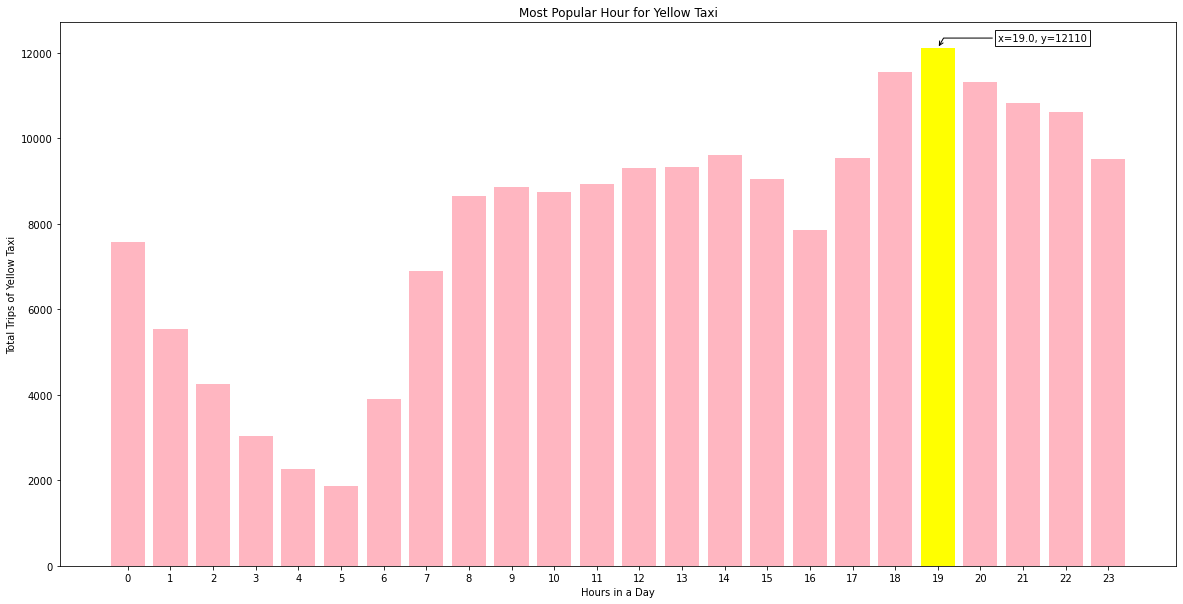

In [639]:
# use a more descriptive name for your function
def most_popular_hour_yt(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    # use the dataframe to pull out values needed to plot
    df = dataframe.copy()
    df["pickup_datetime"] = df["pickup_datetime"].apply(lambda x:datetime.datetime.strftime(x,"%H"))
    values = df.groupby("pickup_datetime").size()
    
    x = np.linspace(0,23,24)
    xmax = x[np.argmax(values)]
    ymax = values.max()
    
    # highlight the bar where trips obtains maximum value
    for i in range(len(x)):
        if values[i] == ymax:
            plt.bar(x[i],values[i],color='yellow')
        else:
            plt.bar(x[i],values[i],color='lightpink')
    
    # add labels and ticks
    plt.xticks(x)
    axes.set_title("Most Popular Hour for Yellow Taxi")
    plt.xlabel("Hours in a Day")
    plt.ylabel("Total Trips of Yellow Taxi")

    
    # add an annotation of the maximum value
    text= "x={}, y={}".format(xmax, ymax)
    ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.9)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.92,0.98), **kw)

    
    plt.show()
    
    

most_popular_hour_yt(yt_df)

### Visualization 2

_Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization._

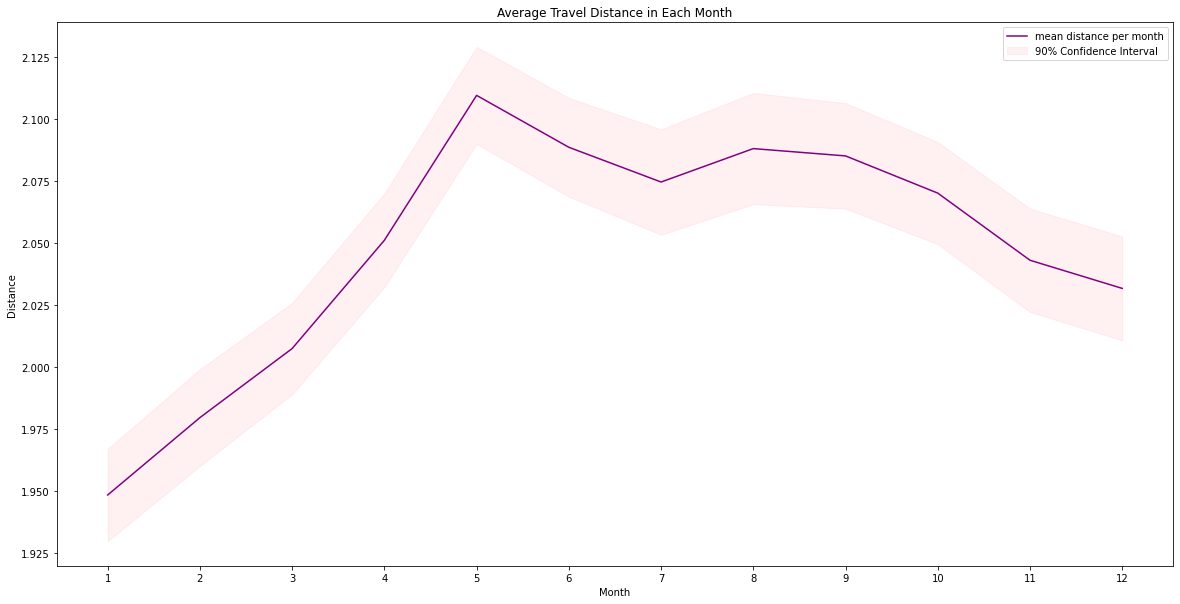

In [640]:
# use a more descriptive name for your function
def ave_distance_monthly(dataframe):
    import scipy.stats as spst
    from scipy.stats import t
    
    figure, axes = plt.subplots(figsize=(20, 10))

    data_total['month'] = data_total['pickup_datetime'].apply(lambda x: datetime.datetime.strftime(x,'%m'))
    N = data_total.groupby("month").count().distance
    mean = data_total.groupby("month").mean().distance
    sigma = data_total.groupby("month").std().distance
    CI_lower = mean - spst.t.ppf(0.05,N-1) * sigma/N**0.5
    CI_upper = mean + spst.t.ppf(0.05,N-1) * sigma/N**0.5

    x=np.linspace(1,12,12)
    plt.plot(x,mean,label='mean distance per month',color="purple")
    plt.fill_between(x,CI_lower,CI_upper,alpha=0.2,label='90% Confidence Interval',color="lightpink")
    axes.set_title("Average Travel Distance in Each Month")
    plt.xticks(x)
    plt.xlabel("Month")
    plt.ylabel("Distance")
    plt.legend()

ave_distance_monthly(trip_total)

### Visualization 3

_Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport._

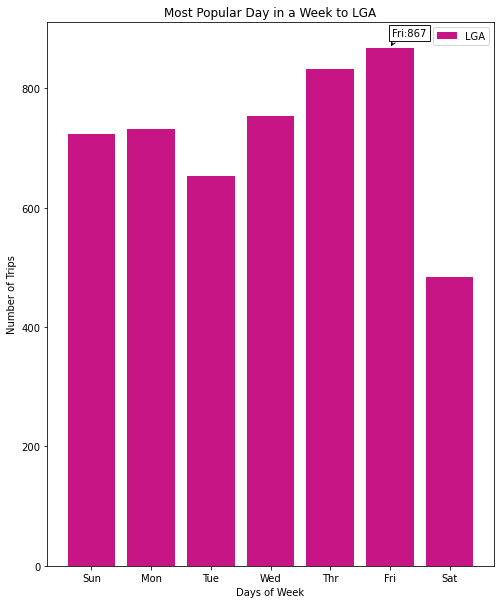

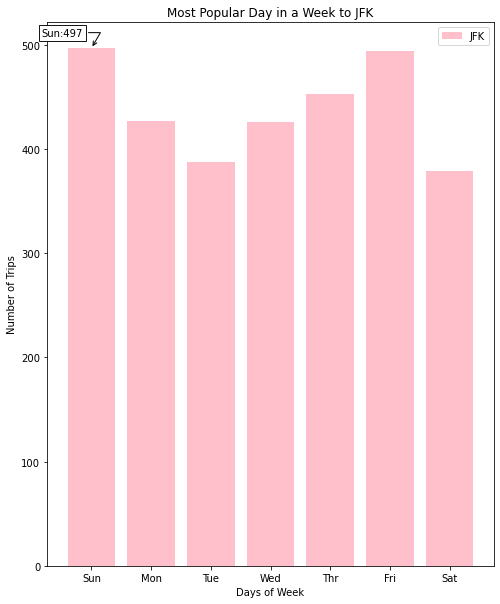

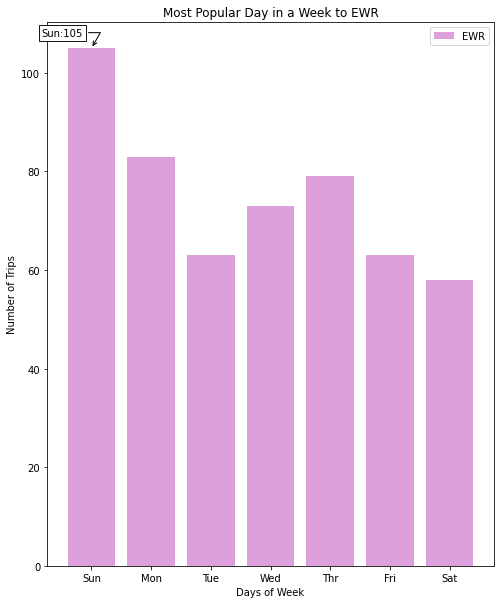

In [641]:
# use a more descriptive name for your function
def airports_dropoffs_day_of_week(dataframe):
    #LGA
    LGA_long1 = -73.887005
    LGA_long2 = -73.853016
    LGA_lat1 = 40.764917
    LGA_lat2 = 40.785976

    #JFK
    JFK_long1 = -73.818959
    JFK_long2 = -73.741711
    JFK_lat1 = 40.617839
    JFK_lat2 = 40.666034

    #EWR
    EWR_long1 = -74.193614
    EWR_long2 = -74.151385
    EWR_lat1 = 40.670644
    EWR_lat2 = 40.708391
    
    def airport_box_dropoff(dataframe,long1,long2,lat1,lat2,airport,col,pos):
        df = dataframe.copy()
        df = df[(df["dropoff_longitude"]>=long1) & (df["dropoff_longitude"]<=long2)]
        df = df[(df["dropoff_latitude"]>=lat1) & (df["dropoff_latitude"]<=lat2)]

        df["day_of_week"] = df["pickup_datetime"].apply(lambda x: datetime.datetime.strftime(x,"%w"))
        values = df.groupby("day_of_week").count().pickup_datetime
        
        
        figure, axes = plt.subplots(figsize=(8, 10))
        x = ["Sun","Mon","Tue","Wed","Thr","Fri","Sat"]
        plt.bar(x,values,color=col,label=f"{airport}")
        plt.xticks(x)
        plt.xlabel("Days of Week")
        plt.ylabel("Number of Trips")
        plt.legend()

        # add an annotation of the maximum value
        xmax = x[np.argmax(values)]
        ymax = values.max()

        text= "{}:{}".format(xmax, ymax)
        ax=plt.gca()
        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.9)
        arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
        kw = dict(xycoords='data',textcoords="axes fraction",
                  arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
        ax.annotate(text, xy=(xmax, ymax), xytext=pos, **kw)
        
        plt.title(f"Most Popular Day in a Week to {airport}")

    airport_box_dropoff(dataframe,LGA_long1,LGA_long2,LGA_lat1,LGA_lat2,"LGA","mediumvioletred",(0.85,0.99))
    airport_box_dropoff(dataframe,JFK_long1,JFK_long2,JFK_lat1,JFK_lat2,"JFK","pink",(0.08,0.99))
    airport_box_dropoff(dataframe,EWR_long1,EWR_long2,EWR_lat1,EWR_lat2,"EWR","plum",(0.08,0.99))
    
airports_dropoffs_day_of_week(trip_total)

### Visualization 4

_Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations._

In [642]:
def heatmap_trips(dataframe):
    import geojsonio
    import folium
    import json
    
    df = dataframe.copy()
    # Divide the area into 20 zones:
    def createZoneTable(zone_factor,westlimit=-74.2635, southlimit=40.4856, eastlimit=-73.7526, northlimit=40.9596):
        zone_table = list()
        #Your code goes here
        lon_list = np.linspace(westlimit,eastlimit,zone_factor+1)
        lat_list = np.linspace(southlimit,northlimit,zone_factor+1)

        k = 0
        for j in range(zone_factor):
            for i in range(zone_factor):
                if i%zone_factor == 0:
                    k += 1
                zone_table.append((str(zone_factor*(k-1)+i),[[lon_list[i],lat_list[j]],
                                          [lon_list[i+1],lat_list[j]],
                                          [lon_list[i+1],lat_list[j+1]],
                                          [lon_list[i],lat_list[j+1]],
                                          [lon_list[i],lat_list[j]]
                                          ]))

        return zone_table
    
    zone_table = createZoneTable(30,westlimit=-74.2635, southlimit=40.4856, eastlimit=-73.7526, northlimit=40.9596)
    
    # Add a new column to label each drop-off position:
    def get_zone(lon,lat,zone_table):
        for zone in zone_table:
            if lon <= zone[1][1][0] and lon >= zone[1][0][0]:
                if lat >= zone[1][0][1] and lat <= zone[1][2][1]:
                    return zone[0]
        return np.nan
    
    df['dropoff_zone'] = df.apply(lambda x: get_zone(x['dropoff_longitude'], x['dropoff_latitude'],zone_table), axis=1)
 

    #Create geojson datafile:
    def createGeoJsonObject(zone_table):
        zone_data_dict = dict()
        zone_data_dict['type'] = 'FeatureCollection'
        zone_data_dict_features = list()
        zone_data_dict['features'] = zone_data_dict_features

        for i in range(len(zone_table)):
            zone_data = zone_table[i]
            zone = zone_data[0]
            zone_box = zone_data[1]
            zone_object = dict()
            zone_object['type'] = 'Feature'
            zone_object['geometry'] = {'type':'Polygon','coordinates':[zone_box]}
            zone_object['properties'] = {'zone_id':zone}
            zone_data_dict_features.append(zone_object.copy())

        return zone_data_dict
    
    geojsonfile = createGeoJsonObject(zone_table)
    
    #Center the map at Times Square
    m = folium.Map(location = [40.7589, -73.9851],zoom_start=12)
    
    groups = df.groupby('dropoff_zone')
    df_2 = pd.DataFrame(groups.size()).rename(columns={0:"dropoff_count"})
    df_2.reset_index(level=0, inplace=True)

    m.choropleth(geo_data=geojsonfile, data=df_2,
             columns=[ 'dropoff_zone','dropoff_count'],
             key_on='feature.properties.zone_id',
             fill_color='RdYlGn_r', fill_opacity=0.4, line_opacity=0.8,
             legend_name='Distribution of Incidents')
    return m

In [643]:
heatmap_trips(trip_total)

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/folium/folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


### Visualization 5

_Create a scatter plot that compares tip amount versus distance._

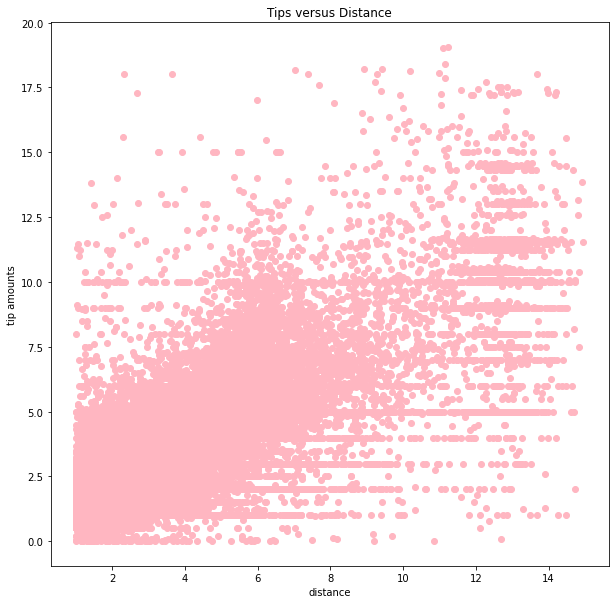

In [644]:
def tip_distance(dataframe):
    figure, axes = plt.subplots(figsize=(10, 10))
    
    df = dataframe.copy()
    df = df[df["tip_amount"].notnull() & (df["tip_amount"]<20) & (df["tip_amount"]!=0)]
    df = df[df["distance"].notnull() & (df["distance"]<15) & (df["distance"]>=1)]
    
    plt.scatter(df["distance"],df["tip_amount"],color="lightpink")
    plt.xlabel("distance")
    plt.ylabel("tip amounts")
    plt.title("Tips versus Distance")

tip_distance(trip_total)    

### Visualization 6

_Create another scatter plot that compares tip amount versus precipitation amount._

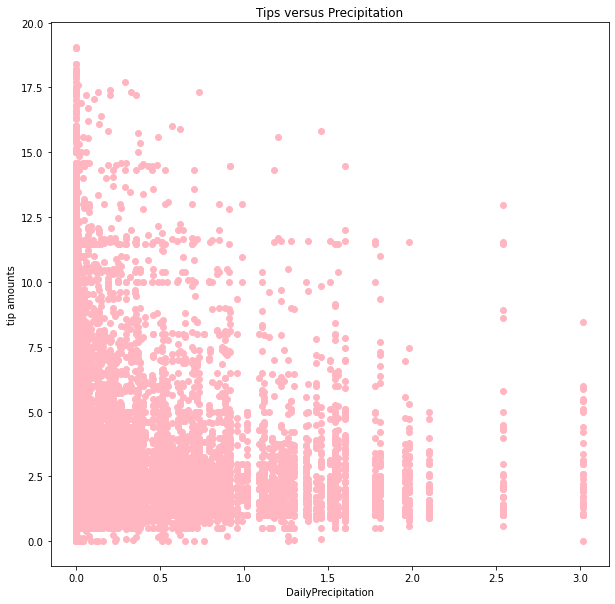

In [645]:
trip_total["DATE"] = trip_total["pickup_datetime"].apply(lambda x:datetime.datetime.strftime(x,"%Y-%m-%d"))
trip_weather = trip_total.merge(weather_daily, how='inner', on='DATE')

def tip_precipitation(dataframe):
    figure, axes = plt.subplots(figsize=(10, 10))
    
    df = dataframe.copy()
    df = df[df["tip_amount"].notnull() & (df["tip_amount"]<20) & (df["tip_amount"]!=0)]
    df = df[df["DailyPrecipitation"].notnull() & (df["DailyPrecipitation"]<4)]
    
    plt.scatter(df["DailyPrecipitation"],df["tip_amount"],color="lightpink")
    plt.xlabel("DailyPrecipitation")
    plt.ylabel("tip amounts")
    plt.title("Tips versus Precipitation")

tip_precipitation(trip_weather)

### Visualization 7

_Create another scatter plot that compares tip amount versus sustained wind speed._

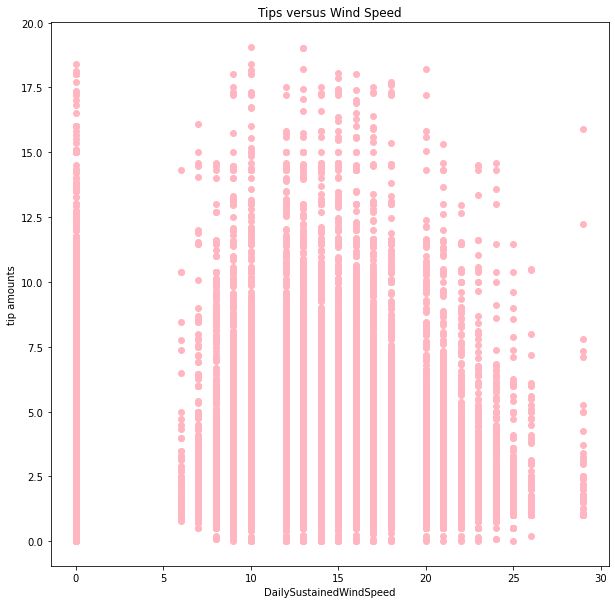

In [646]:
#Use three tables: uber_df, yt_df and weather_daily_df
def tip_wind(dataframe):
    figure, axes = plt.subplots(figsize=(10, 10))
    
    df = dataframe.copy()
    df = df[df["tip_amount"].notnull() & (df["tip_amount"]<20) & (df["tip_amount"]!=0)]
    df = df[df["DailySustainedWindSpeed"].notnull() & (df["DailySustainedWindSpeed"]<30)]
    
    plt.scatter(df["DailySustainedWindSpeed"],df["tip_amount"],color="lightpink")
    plt.xlabel("DailySustainedWindSpeed")
    plt.ylabel("tip amounts")
    plt.title("Tips versus Wind Speed")

tip_wind(trip_weather)

### Visualization 8

Create a visualization that compares the number of trips traveled per hour by uber and by yellow taxi.

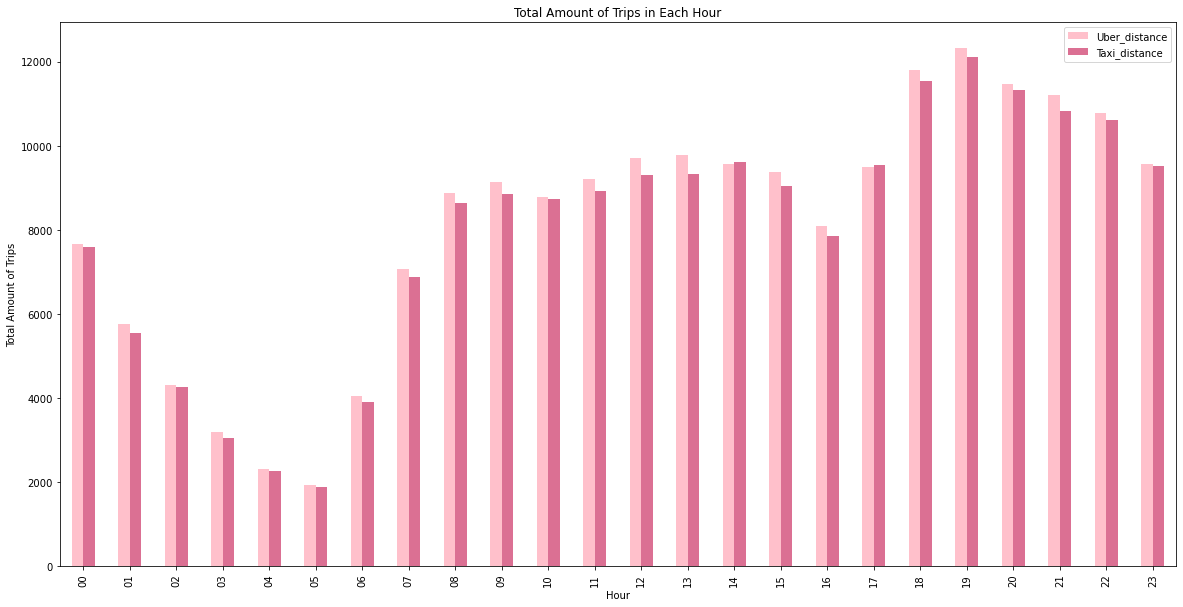

In [647]:
#Uber:
df1 = uber_df.copy()
df1["Uber_distance"] = df1["distance"]
df1['hour'] = df1['pickup_datetime'].apply(lambda x: datetime.datetime.strftime(x,'%H'))
uber_hourly = df1.groupby("hour").count().Uber_distance

#Yellow taxi:
df2 = yt_df.copy()
df2["Taxi_distance"] = df2["distance"]
df2['hour'] = df2['pickup_datetime'].apply(lambda x: datetime.datetime.strftime(x,'%H'))
yt_hourly = df2.groupby("hour").count().Taxi_distance

uber_yt_hourly = pd.concat([uber_hourly,yt_hourly],axis=1)

def ave_distance_hourly(dataframe):
    
    dataframe.plot.bar(color=["pink","palevioletred"],figsize=(20,10))
    
    # add labels and ticks
    x = np.linspace(0,23,24)
    plt.xticks(x)
    plt.title("Total Amount of Trips in Each Hour")
    plt.xticks(x)
    plt.xlabel("Hour")
    plt.ylabel("Total Amount of Trips")

ave_distance_hourly(uber_yt_hourly)

### Visualization 9

During Hurricane Sandy in NYC (Oct 29-30, 2012), plus the week leading up and the week after, how many trips were taken each hour, and compare it to the average number of trips during Oct,2012.

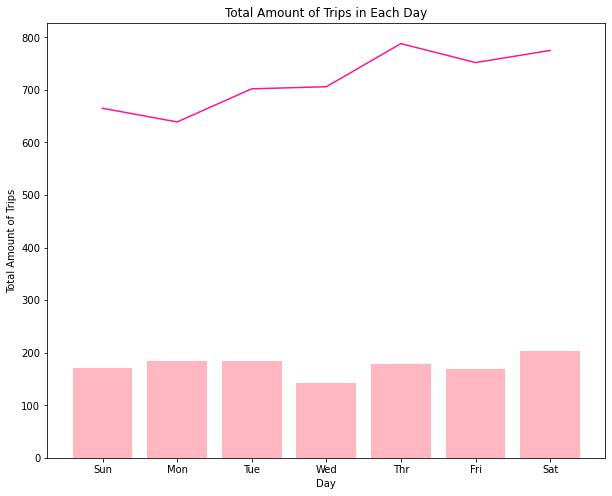

In [648]:
def total_trips_daily(dataframe):
    figure, axes = plt.subplots(figsize=(10, 8))
    
    df1 = dataframe.copy()
    df1 = df1[(df1['pickup_datetime']>="2012-10-01") & (df1['pickup_datetime']<="2012-10-30")]
    df1['day'] = df1['pickup_datetime'].apply(lambda x: datetime.datetime.strftime(x,'%w'))
    values1 = df1.groupby("day").count().distance
    
    df2 = dataframe.copy()
    df2 = df2[(df2['pickup_datetime']>="2012-10-22") & (df2['pickup_datetime']<="2012-10-30")]
    df2['day'] = df2['pickup_datetime'].apply(lambda x: datetime.datetime.strftime(x,'%w'))
    values2 = df2.groupby("day").count().distance
    

    x = ["Sun","Mon","Tue","Wed","Thr","Fri","Sat"]
    plt.plot(x,values1,color="deeppink",label="Daily Trips in October")
    plt.bar(x,values2,color="lightpink",label="Daily Trips during Hurricane")
    
    plt.xticks(x)
    plt.title("Total Amount of Trips in Each Day")
    plt.xticks(x)
    plt.xlabel("Day")
    plt.ylabel("Total Amount of Trips")
    plt.legend
    
total_trips_daily(trip_total)   